In [5]:
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


import re
from pathlib import Path
from collections import defaultdict
import random
from itertools import permutations

import pandas as pd
import torch
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")

CLEAN_DIR = PROJECT_ROOT / "data" / "wavs"
TTS_DIR = PROJECT_ROOT / "data" / "tts" / "f5"
EMBEDDS_DIR = PROJECT_ROOT / "data" / "embeddings"
EMBEDDS_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR = PROJECT_ROOT / "output"
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = PROJECT_ROOT / "data" / "models" / "real_vs_fake"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("DEVICE:", DEVICE)
print("CLEAN_DIR:", CLEAN_DIR)
print("TTS_DIR:", TTS_DIR)
print("EMBEDDS_DIR:", EMBEDDS_DIR)
print("MODEL_DIR:", MODEL_DIR)

DEVICE: cuda
CLEAN_DIR: /home/SpeakerRec/BioVoice/data/wavs
TTS_DIR: /home/SpeakerRec/BioVoice/data/tts/f5
EMBEDDS_DIR: /home/SpeakerRec/BioVoice/data/embeddings
MODEL_DIR: /home/SpeakerRec/BioVoice/data/models/real_vs_fake


In [7]:
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)

Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


In [8]:
def embed_with_redim(wav_path: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)  # [C, T]
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]  # take first channel

    wav = wav.to(DEVICE)
    with torch.no_grad():
        emb = redim_model(wav)  # [1, 192]
    return emb.squeeze(0).cpu().numpy()  # [192]


def collect_wavs(base_dir: Path):
    wavs = []
    for wav_path in base_dir.rglob("*.wav"):
        wavs.append(wav_path)
    return sorted(wavs)


real_wavs = collect_wavs(CLEAN_DIR)
fake_wavs = collect_wavs(TTS_DIR)

print(f"Found {len(real_wavs)} real wavs")
print(f"Found {len(fake_wavs)} fake wavs")

Found 90 real wavs
Found 90 fake wavs


In [9]:
real_embeddings = []

for wav_path in tqdm(real_wavs, desc="Embedding REAL"):
    try:
        emb = embed_with_redim(str(wav_path))
        real_embeddings.append(emb)
    except Exception as e:
        print(f"Failed on {wav_path}: {e}")

real_embeddings = np.stack(real_embeddings)
print("Real embeddings shape:", real_embeddings.shape)

Embedding REAL: 100%|██████████| 90/90 [00:09<00:00,  9.34it/s]

Real embeddings shape: (90, 192)


In [10]:
fake_embeddings = []

for wav_path in tqdm(fake_wavs, desc="Embedding FAKE"):
    try:
        emb = embed_with_redim(str(wav_path))
        fake_embeddings.append(emb)
    except Exception as e:
        print(f"Failed on {wav_path}: {e}")

fake_embeddings = np.stack(fake_embeddings)
print("Fake embeddings shape:", fake_embeddings.shape)

Embedding FAKE: 100%|██████████| 90/90 [00:07<00:00, 12.15it/s]

Fake embeddings shape: (90, 192)


In [11]:

np.save(EMBEDDS_DIR / "redimnet_team_embeddings_real.npy", real_embeddings)
np.save(EMBEDDS_DIR / "redimnet_team_embeddings_fake.npy", fake_embeddings)

print("Saved embeddings to:", EMBEDDS_DIR)

Saved embeddings to: /home/SpeakerRec/BioVoice/data/embeddings


In [12]:
Xr = np.load(EMBEDDS_DIR / "redimnet_team_embeddings_real.npy")
Xf = np.load(EMBEDDS_DIR / "redimnet_team_embeddings_fake.npy")

print(Xr.shape, Xf.shape)
print("Embedding dim:", Xr.shape[1])

(90, 192) (90, 192)
Embedding dim: 192


In [13]:
y_real = np.zeros(len(Xr))
y_fake = np.ones(len(Xf))

X = np.vstack([Xr, Xf])
y = np.concatenate([y_real, y_fake])

print("Total samples:", X.shape[0])
print("Embedding dim:", X.shape[1])

Total samples: 180
Embedding dim: 192


In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)

Train: (144, 192)
Validation: (36, 192)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [16]:
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

clf.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [17]:
y_pred = clf.predict(X_val_scaled)
y_prob = clf.predict_proba(X_val_scaled)[:, 1]

acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)
cm = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Real", "Fake"]))

Accuracy: 1.0000
ROC-AUC: 1.0000
Confusion Matrix:
[[18  0]
 [ 0 18]]

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00        18
        Fake       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [18]:
with open(MODEL_DIR / "logistic_regression.pkl", "wb") as f:
    pickle.dump(clf, f)

with open(MODEL_DIR / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved to:", MODEL_DIR)

Model and scaler saved to: /home/SpeakerRec/BioVoice/data/models/real_vs_fake


In [19]:
rows = []

# Real
for p in (PROJECT_ROOT / "data" / "wavs").rglob("*.wav"):
    rows.append({"path": str(p), "label": 0})

# Fake
for p in (PROJECT_ROOT / "data" / "tts" / "f5").rglob("*.wav"):
    rows.append({"path": str(p), "label": 1})

df_rf = pd.DataFrame(rows, columns=["path", "label"])

CSV_PATH = PROJECT_ROOT / "data" / "real_fake_paths.csv"
df_rf.to_csv(CSV_PATH, index=False)

print("Saved:", CSV_PATH)
print(df_rf["label"].value_counts())

Saved: /home/SpeakerRec/BioVoice/data/real_fake_paths.csv
0    90
1    90
Name: label, dtype: int64


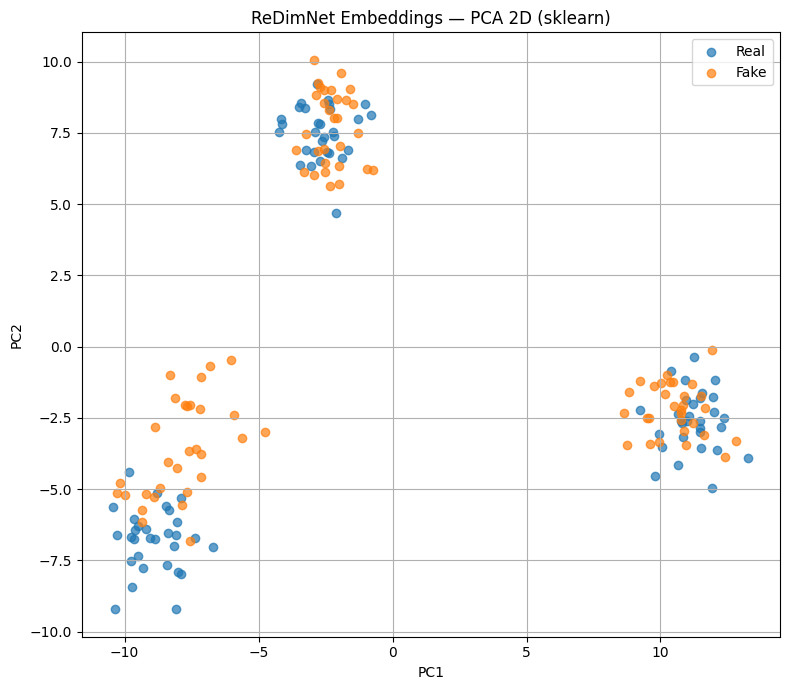

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
# Fit PCA on all embeddings
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)  # shape [N, 2]
pca2d = X_pca  # first 2 PCs
labels = y  # 0 for real, 1 for fake
plt.figure(figsize=(8, 7))
for label in np.unique(labels):
    idx = labels == label
    label_name = "Real" if label == 0 else "Fake"
    plt.scatter(pca2d[idx, 0], pca2d[idx, 1], alpha=0.7, label=label_name)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet Embeddings — PCA 2D (sklearn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
